## GeoRulesLobePy: Deep Marine-Lobes
This Package is used to build 3d models of deep marine lobes using rule-based models.

### I. Getting Started
1. Dowload repository from : https://github.com/chaconnb/GeoRulesLobePy
2. Follow the README to activate the georules environment and package.

### II. Load the required libraries 
The following code loads the required libraries.

In [16]:
import numpy as np
import math 
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.lines import Line2D
from collections import Counter
from pathlib import Path
import pyvista as pv
import shutil
pv.set_jupyter_backend('client')

from georuleslobepy.S_ProbMap import Lobe_map
from georuleslobepy.variance_bathymetry import varinace_bathymetry_maps
from georuleslobepy.utils import save_bath_as_array
from georuleslobepy.S_3Dgrid_healing import sandbox
from georuleslobepy.visualization.V_grid import grid
from georuleslobepy.visualization.visualization_utils import angle_between
from georuleslobepy.visualization.visualization_utils import lobe_max_thickness
from georuleslobepy.utils import load_list_json
from georuleslobepy.utils import load_array
from georuleslobepy.utils import save_bath_as_array
from georuleslobepy.utils import save_list_as_json
from georuleslobepy.utils import save_centroids
from georuleslobepy.utils import save_array

import warnings
warnings.filterwarnings('ignore')


### III. Set up a Resutls Directory


In [17]:
def setup_results_directory():
    RESULTS_DIR = Path("./results")
    if RESULTS_DIR.exists(): 
        shutil.rmtree(RESULTS_DIR)

    CENTROIDS = RESULTS_DIR.joinpath('centroids')
    SURF_VAR = RESULTS_DIR.joinpath('surface_variance')
    GRID_INPUTS = RESULTS_DIR.joinpath('3d_grid_inputs')

    for d in [RESULTS_DIR, CENTROIDS, SURF_VAR, GRID_INPUTS]: 
        d.mkdir()

In [18]:
setup_results_directory() 

### VI. Simulation
The following code runs simulations to create different 3d deepmarine-lobe models.

### VI.I. User input Parameters:

- The following parameters need to be input by the user:  <br>

    * **nx** : (int) Sandbox size in the x direction.  <br>

    * **ny** : (int) Sandbox size in the y direction.  <br>

    * **cell_size** : (int)  Size of each cell in m. <br>

    * **width** : (int) Maximum lobe width in m.  <br>
    
    * **lenght** : (int) Maximum lobe lenght in m.  <br>

    * **tmax** : (int)  Maximum height of lome in m.  <br> 

    * **num_of_lobes** : (int)  Number of lobes to deposit.  <br>

    * **transition_matrix** : (np.array) Transition matrix for Markov chain.  <br>

    * **startstate** : (string)  Starting state for generating Markov chain.  <br>

    * **quadrant angles** : (dictionary) A dictionary with keys representing Markov states and values containing a list of angles indicating the starting and ending points for each key.  <br>

    * **source** : (list)  Coordinate where the source of sediment (channel) is located in the sandbox.  <br>

    * **cellsize_z**: (int) Size of each cell on the z-axis.  <br>

    * **n_mud**: (int)  Maximum number of mud cells that will be input into the sandbox at the 'HF' Markov state.  <br>

    * **states**: (list with strings) List of Markov states.  <br>

    * **n_test**: (int) Number of 3d models being built.  <br>

    * **global_property**: (float) Total percentage in decimal of propetry the facies are modelling.

    * **n_cell_mud**: (int) Number of cells of mud that will cover each lobe element.

In [19]:
#Parameter Settings

#Reservoir Parameters

_transition_matrix  = np.array([
        [0.1,0.13,0.3,0.15,0.22,0.1],
        [0.3,0.05,0.3,0.15,0.15,0.05],
        [0.3,0.13,0.1,0.15,0.18,0.14],
        [0.25,0.1,0.25,0.09,0.22,0.09],
        [0.05,0.25,0.25,0.25,0.05,0.15],
        [0.15,0.25,0.25,0.25,0.05,0.05], 
    ])

inpt_lobmaps = {
    "width": 15000,      # meters
    "tmax": 2,          # meters 
    "lenght" : 30000,   # meters  
    "num_of_lobes" : 10,       # number of lobes
    "cell_size" : 100,   #cell size
    "nx" : 250,
    "ny" : 250,  
    "transition_matrix" : _transition_matrix,   # transition matrix
    "startstate" : "Q2",              # start states can be ["Q1","Q2","Q3","Q4","NMA","HF"]
    "quadrant_angles" : {              # lists of quadrants with their angles
        "Q1": [315, 45],
        "Q2": [45, 135],
        "Q3": [135, 225],
        "Q4": [225, 315]
        }, 
    "source": [25, 200],    #source of the sediment (channel)
    "cellsize_z": 0.15,
    "n_mud": 2,            #number of cells mud that covers lobe
    "states": ['Q1', 'Q2', 'Q3', 'Q4', 'NMA', 'HF']
} 

#number of simulations

n_test = 20

#input 3D-visualization

global_property = 0.15
mud_property = 0.18
n_cell_mud = 2


### IV.II Run Simulations
Run n_test number of simulations. Output will be store in the **results** folder. Each simulation is a new 3d model.

In [20]:
n = 0

while n < n_test:
        
    result = Lobe_map(**inpt_lobmaps)
    
    (
        Bathymetry_maps,
        centroids,
        prob_maps,
        quadrants,
        angle_stack,
        columns_corner,
        rows_corner,
        lobe_image
    ) = result
           
    
    ##Calculates Variance of thicknesses in bathymetry maps
    variance_thickness = varinace_bathymetry_maps(Bathymetry_maps)
        
    save_array("variance_thickness{}".format(n),"results/surface_variance/",variance_thickness)
        
    #Turn list of bathymetry maps to arrays and save array to a file
    save_bath_as_array("bathy_array{}".format(n),"results/3d_grid_inputs/", Bathymetry_maps)
        
    #save centroids
    save_centroids("centroids{}".format(n),"results/centroids/", centroids)
        
    #Save lists as json files
    save_list_as_json("angle_stack{}".format(n),"results/3d_grid_inputs/", angle_stack)
    save_list_as_json("columns_corner{}".format(n),"results/3d_grid_inputs/", columns_corner)
    save_list_as_json("rows_corner{}".format(n),"results/3d_grid_inputs/", rows_corner)
    save_list_as_json("quadrants{}".format(n),"results/3d_grid_inputs/", quadrants)
        
    n = n + 1
    print("Simulation:",n) #Track Progress
        

Simulation: 1
Simulation: 2
Simulation: 3
Simulation: 4
Simulation: 5
Simulation: 6
Simulation: 7
Simulation: 8
Simulation: 9
Simulation: 10
Simulation: 11
Simulation: 12
Simulation: 13
Simulation: 14
Simulation: 15
Simulation: 16
Simulation: 17
Simulation: 18
Simulation: 19
Simulation: 20


### V. Results Visualizations
The following code creates visualizations of the statistics generated by the simulations and visualizes the models in 3D.  <br>
* **Visualization Statistics Plots:** <br>
    
    - **Lag Angle plot** : Visualization of the lag angle, in a rose diagram. Lag angle refers to the azimuth angle created by the plane formed by $centroid_{n}$ to $centroid_{n+1}$. This angle describes the movement from $lobe_{n}$ to $lobe_{n+1}$.
    - **Frequency Markov States** :  Bar plot showing the percentage frequencies of Markov states generated for each simulation.
    - **Surface Variance** : Graph showing thickness variances in each bathymetry map for every simulation.
    - **Thickness of lobes** : Box plot showing the biggest thickness for the new lobe in each bathymetry map for every simulation.

* **3D Visualizations:**

### V.I Load Data
Load the data generated in section II.II.


In [21]:
#list with quadrants (Markov State) for every realiz
total_quadrants = []
# list with centroids for every simulation
total_centroids = []
# list with surface variance for every simulation
total_variance = []
#list with bathymetry maps for every simulation
total_bathymetry_maps = []
#list with angle stack for every simulation
total_angle_stack = []
#list with column corners for every simulation
total_column_corner = []
#list with column corners for every simulation
total_row_corner = []


for n in range(0,n_test):
    
    total_quadrants.append(load_list_json("quadrants{}".format(n),'results/3d_grid_inputs/'))
    total_centroids.append(load_array("centroids{}".format(n),'results/centroids/'))
    total_variance.append(load_array("variance_thickness{}".format(n),"results/surface_variance/"))
    total_bathymetry_maps.append(load_array("bathy_array{}".format(n),'results/3d_grid_inputs/'))
    total_angle_stack.append(load_list_json("angle_stack{}".format(n),'results/3d_grid_inputs/'))
    total_column_corner.append(load_list_json("columns_corner{}".format(n),'results/3d_grid_inputs/'))
    total_row_corner.append(load_list_json("rows_corner{}".format(n),'results/3d_grid_inputs/'))

### V.II Data Pre-Processing
Process uploaded data to generate visualizations.

#### V.II.I Lag Angle Plot

In [22]:
# Find the angles at which centroids move.
angles = []

for n in range(0,n_test): 
    centroids = total_centroids[n]

    #Remove rows containing "nan" values
    # Find rows that do not contain NaN values
    valid_rows = ~np.isnan(centroids).any(axis=1)

    # Use boolean indexing to select rows without NaN
    centroids = centroids[valid_rows]

    # Find the angle between three points - the reference point is grid center
    for i in range(len(centroids)-1):
        a = centroids[i]
        b = centroids[i+1]
        start_coordinate = np.array([0,a[1]])
        angles.append(angle_between(a, start_coordinate,b))

theta = np.linspace(0,360,37)

# Create pais in the theta using list comprehension
theta_pairlist = [[theta[i], theta[i + 1]] for i in range(0, len(theta)-1)]

# #Convert lists to numpy arrays for easier manipulation
angles_array = np.array(angles)
intervals_array = np.array(theta_pairlist)

# #Initialize a list to store the count of angles in each interval
angle_counts = [] 

for interval in intervals_array:
    # Filter angles within the current interval
    filtered_angles = angles_array[(angles_array >= interval[0]) & (angles_array < interval[1])]

    # Count the number of angles in the interval
    count = len(filtered_angles)

    # Store the count in the list
    angle_counts.append(count)


# #calculate the mean of each pair to be able to plot it 
pairlist_mean = [int(sum(pair) / len(pair)) for pair in theta_pairlist]

#transform the pairlist_mean from degrees to radians
pairlist_mean = np.radians(pairlist_mean)

#transform angle_counts from list to an array
angle_counts = np.array(angle_counts)

#### V.II.II Frequency of Markov-States Plot

In [23]:
#combine the lists of quadrants
flattened_quadrants_list = [item for sublist in total_quadrants for item in sublist]

# Calculate the frequency of each quadrant
frequency_counter = Counter(flattened_quadrants_list)

# Extract the quadrants and their frequencies
quadrants = list(frequency_counter.keys())
frequencies = list(frequency_counter.values())

#Calculate percentages from frequencies
frequencies_percentage = [ i * 100/sum(frequencies) for i in frequencies]

#### V.III.III Surface Varaince Plot

In [24]:
#create array of zeros to store the variances of the bathymetry maps
#Add four columns to the array to accommodate space for p10, p25, p85, and p90 values for each row.
#Add one row, as there are n_lobes + 1 bathymetry maps, with the first one being just an array of zeros.
array_variances_percentiles = np.zeros((inpt_lobmaps["num_of_lobes"]+1,n_test+5))

for n in range(0,n_test): 

    variance_bathymetry = total_variance[n]
    array_variances_percentiles[:,n] = variance_bathymetry


#Find P10, P25, P85 and P90

for n in range(inpt_lobmaps["num_of_lobes"]+1):
    #p10
    array_variances_percentiles[n,n_test] = np.percentile(array_variances_percentiles[n,:n_test],10)
    #p25
    array_variances_percentiles[n,n_test+1] = np.percentile(array_variances_percentiles[n,:n_test],25)
    #p50
    array_variances_percentiles[n,n_test+2] = np.percentile(array_variances_percentiles[n,:n_test],50)
    #p75
    array_variances_percentiles[n,n_test+3] = np.percentile(array_variances_percentiles[n,:n_test],75)
    #p90
    array_variances_percentiles[n,n_test+4] = np.percentile(array_variances_percentiles[n,:n_test],90)

#### V.III.IV Thickness box-plot

In [25]:
#array for saving max thickness for each lobe on each simulation
lobe_thickness_realizations = np.zeros((inpt_lobmaps["num_of_lobes"], n_test))

#Data prep
for n in range(0,n_test):
    #Load quadrants for each simulation
    output_quadrants = total_quadrants[n]
    #Load bathymetry maps
    bathymetry_array = total_bathymetry_maps[n]
    #Remove the first bathymetry map from the bathymetry array as it doesn't contain any lobes (only zeros).
    bathymetry_array = bathymetry_array[1:len(bathymetry_array),:,:]


    for i in range(len(output_quadrants)): 
        if output_quadrants[i] != "HF":
            if i == 0:
                lobe_thickness_realizations[i,n-1] = np.max(bathymetry_array[0,:,:])
            else:
                lobe_thickness_realizations[i,n-1] = lobe_max_thickness(bathymetry_array[i-1,:,:],bathymetry_array[i,:,:])


# Replace zeros with the mean of each column (lobe)
lobe_thickness_nan = np.where(lobe_thickness_realizations == 0, np.nan, lobe_thickness_realizations)
# Calculate the mean of each column excluding NaN values
col_means = np.nanmean(lobe_thickness_nan, axis=0)
# Replace zeros with the mean of each column
lobe_thickness_no_zeros = np.where(lobe_thickness_realizations == 0, col_means, lobe_thickness_realizations)


# #create a list of lists with the thickneses for the  n_lobes for the n_test simulations.
lobe_thickness_list = [row.tolist() for row in lobe_thickness_no_zeros]

### V.III Plot Statistics Visualization

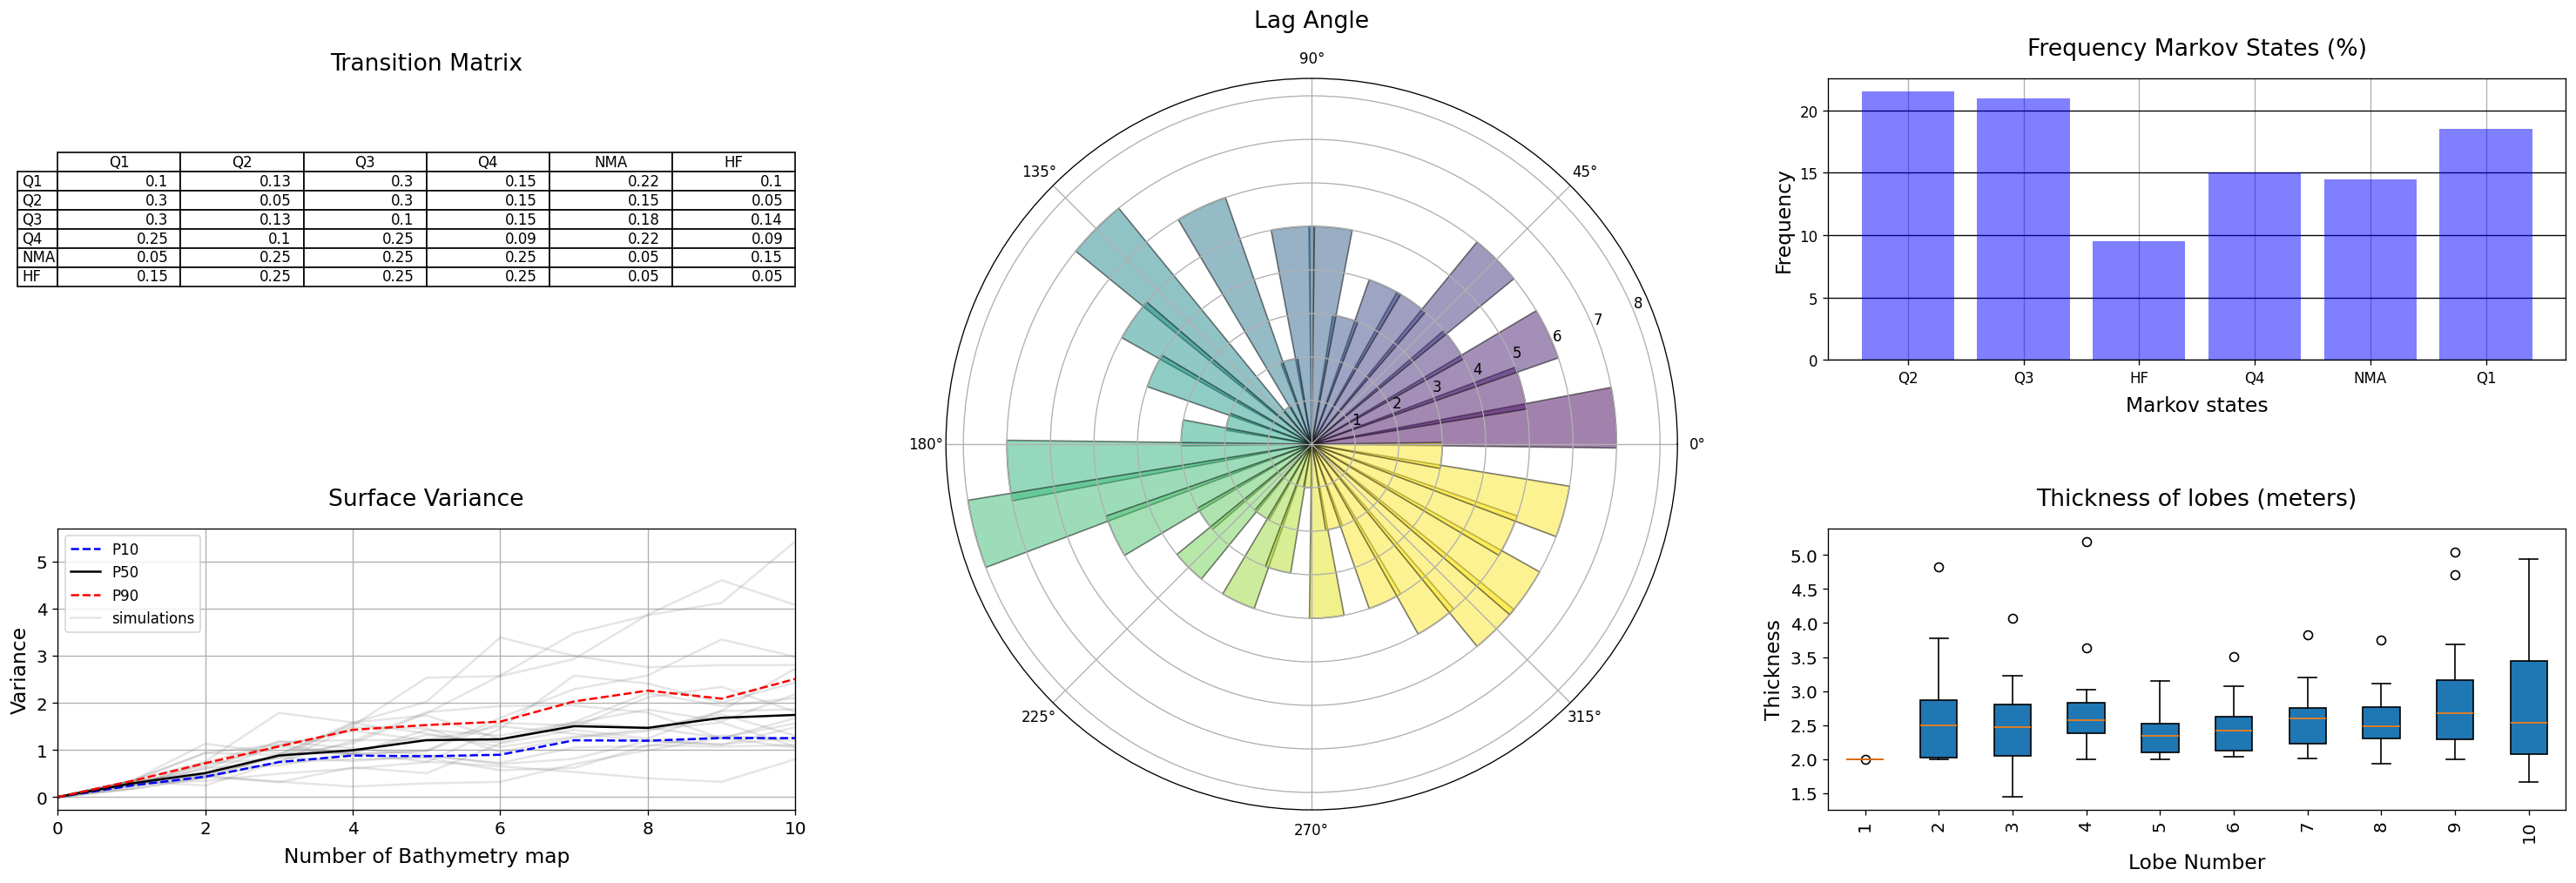

In [26]:
fig = plt.figure(figsize=(12, 7),dpi=120)
grid_spec = gridspec.GridSpec(ncols = 3,nrows=2,width_ratios=[2, 2, 2])

ax0 = fig.add_subplot(grid_spec[0])
ax0.axis('tight')
ax0.axis('off')
the_table = ax0.table(cellText=_transition_matrix,rowLabels=inpt_lobmaps["states"],colLabels=inpt_lobmaps["states"],loc='center')
plt.title('Transition Matrix', fontsize=16)

ax1 = fig.add_subplot(grid_spec[1])
ax1.axis('off')
# Plot polar bar graph
# Get an axes handle/object
ax1 = plt.subplot(projection ="polar")
# Plot
bars = ax1.bar(x = pairlist_mean, height= angle_counts,
        color=plt.cm.viridis(pairlist_mean/ 5.),
        width=0.2,
        bottom=0.0,
        alpha=0.5,
        edgecolor='k')
# Additional Tweaks
plt.grid(True)
plt.title("Lag Angle", fontsize=16, pad=16)

ax2= fig.add_subplot(grid_spec[2])
# Plot the bar graph
plt.grid()
plt.bar(quadrants, frequencies_percentage, color='blue', zorder=2,alpha =0.5)
# Plot the grid with a lower zorder value
plt.grid(axis='y', zorder=1,color ='black')
plt.xlabel('Markov states',fontsize=14,labelpad=7)
plt.ylabel('Frequency',fontsize=14)
plt.title('Frequency Markov States (%)', fontsize=16, pad=16)

### Surface Variance
##### plot variance vs surface and percentiles
ax3 = fig.add_subplot(grid_spec[3])

bathy_lenght = list(range(0,inpt_lobmaps["num_of_lobes"]+1))
for n in range(n_test):

    # # set the title of a plot 
    plt.title("Surface Variance", fontsize=16, pad=16)

    # # plot scatter plot with x and y data 
    plt.plot(bathy_lenght,array_variances_percentiles[:,n],alpha=0.2,color ="gray") 
#label different realizations
line = Line2D([0], [0], label='simulations', color='gray',alpha =0.2)

plt.plot(bathy_lenght,array_variances_percentiles[:,n_test+1],"b--", label = 'P10') #p10
plt.plot(bathy_lenght,array_variances_percentiles[:,n_test+2],"k", label = 'P50') #p50
plt.plot(bathy_lenght,array_variances_percentiles[:,n_test+3],"r--", label = 'P90') #p90 

plt.xlim([0, inpt_lobmaps["num_of_lobes"]]) 
plt.xlabel('Number of Bathymetry map',fontsize=14,labelpad=7)
plt.ylabel('Variance',fontsize=14) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
#legend
handles, labels = ax3.get_legend_handles_labels()
handles.append(line)
plt.legend(handles=handles)


### Lobe thickness
ax5 = fig.add_subplot(grid_spec[5])
labels = list(map(str, range(1, inpt_lobmaps["num_of_lobes"]+1)))

#boxplot
plt.boxplot(lobe_thickness_list, vert=True, patch_artist=True, labels=labels) 
plt.ylabel('Thickness',fontsize=14)
plt.xlabel('Lobe Number',fontsize=14,labelpad=7)
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.title("Thickness of lobes (meters)", fontsize=16, pad=16)



plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.6); plt.show()

### VI. Visualizations: 3D models

Select a simulation or 3D model to be displayed in the cell below.

In [27]:
display_model = 3 #Choose a simulation/model to be displayed.

Load the inputs and run the sandbox function, which will create a 3D array from the bathymetry maps calculated in the Lobe_map function.

In [28]:
bathymetry_map = total_bathymetry_maps[display_model]
nz = math.ceil(np.max(bathymetry_map[len(bathymetry_map)-1])) + 5 #Find maximum height 

#input sandboxgrid function
inpt_sandbox = {
    "lobe_length": inpt_lobmaps["lenght"],
    "lobe_wmax": inpt_lobmaps["width"],
    "cell_size" :inpt_lobmaps["cell_size"],
    "lobe_image": lobe_image,   #array of thickness of lobe
    "cellsize_z": inpt_lobmaps["cellsize_z"], 
    "lobe_tmax": inpt_lobmaps["tmax"],
    "global_prop": global_property,
    "mud_property": mud_property,
    "n_cell_mud": n_cell_mud,
    "a1": 0.66,
    "a2": 0.33,
    "nx": inpt_lobmaps["nx"],
    "ny": inpt_lobmaps["ny"],
    "nz": nz,
    "n_lobe": inpt_lobmaps["num_of_lobes"],
    "angle_stack": total_angle_stack[display_model],       # list of lobe apices with respect to the source
    "columns_corner": total_column_corner[display_model],  # list of the locations of the top-left corners of the lobe images for
                                                            # each lobe with respect to the bathymetry map.
    "rows_corner": total_row_corner[display_model],   # list of the locations of the top-left rows of the lobe images for
                                                      # each lobe w.r.t. the bathymetry map. 
    "Bathymetry_maps": bathymetry_map,   #list of bathymetry maps for each simulation
    "quadrants": total_quadrants[display_model]
} 


sandbox_grid = sandbox(**inpt_sandbox) # 3D array with properties (e.g., sandstone percentage) represented in each cell."

lobe 1
lobe 2
lobe 3
lobe 4
lobe 5
lobe 6
lobe 7
lobe 8
lobe 9
lobe 10


### Plot 3d interactive model! 

grid function has the following options: 
* **plot_slices** = True <br>
Plot slices of the volume in the x,y and z-direction.
    * **slice_x**: Slice number that will be visualize in x-axis. 
    * **slice_y**: Slice number that will be visualize in y-axis.
    * **slice_z**: Slice number that will be visualize in z-axis. 
* **plot grid** = True <br>
Plot 3d grid. 
* **plot orthogonal** = True <br>
View orthogonal slices from the 3d array sandbox_grid. 

In [29]:
grid(sandbox_grid,1,1,1,plot_slices=True, slice_x=40, slice_y=30, slice_z=2)
#grid(sandbox_grid,1,1,1,plot_orthogonal=True)


Widget(value='<iframe src="http://localhost:59821/index.html?ui=P_0x28669488250_2&reconnect=auto" class="pyvis…